In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv("C:/Users/user/Desktop/thesis_20240516/Vasicek_group1/vasicek_group1_portfolio1.csv", low_memory=False)

In [3]:
# Explicitly list the column names to be dropped
columns_to_drop = [
    'correlation', 
    'PD_700', 'Estimated_Loss_700',
    'PD_750', 'Estimated_Loss_750',
    'PD_800', 'Estimated_Loss_800',
    'PD_850', 'Estimated_Loss_850',
    'PD_900', 'Estimated_Loss_900',
    'PD_950', 'Estimated_Loss_950',
    'PD_990', 'Estimated_Loss_990',
    'PD_999', 'Estimated_Loss_999'
]

# Drop the columns
data = data.drop(columns=columns_to_drop)

# Select rows where grade is 'B'
df = data[data['grade'] == 'B']

In [4]:
# Calculate the loss rate for each row
df['loss_rate'] = df['loss'] / df['exposure']

# Filter the dataset for rows where 'actual_class' is 1
subset_actual_class_1 = df[df['actual_class'] == 1]

# Calculate the weighted average loss rate for the entire dataset where 'actual_class' is 1
if not subset_actual_class_1.empty:  # Check if the subset is not empty
    weighted_avg_loss_rate_actual_class_1 = (subset_actual_class_1['loss_rate'] * subset_actual_class_1['exposure']).sum() / subset_actual_class_1['exposure'].sum()
    print("Weighted Average Loss Rate for entire dataset where actual_class is 1:")
    print(weighted_avg_loss_rate_actual_class_1)
else:
    print("No data for actual_class = 1.")


Weighted Average Loss Rate for entire dataset where actual_class is 1:
0.4588672801341739


C:\Users\user\AppData\Local\Temp\ipykernel_31128\2780636040.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loss_rate'] = df['loss'] / df['exposure']


In [5]:
from scipy.stats import norm


correlation = 0.0253

loss_rate = 0.45601883882800387

# Define the confidence levels and their corresponding quantiles
confidence_levels = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999]

# Create a new DataFrame for the output
df_1 = df.copy()

# Calculate PD at different confidence levels using the Vasicek model
for i, conf_level in enumerate(confidence_levels):
    pd_column_name = f'PD_{int(conf_level * 1000)}'
    quantile = norm.ppf(conf_level)
    df_1[pd_column_name] = norm.cdf(
        (norm.ppf(df_1['uncon_PD']) + quantile * np.sqrt(correlation)) / np.sqrt(1 - correlation)
    )
    
    # Calculate the estimated loss for the confidence level
    estimated_loss_column_name = f'Estimated_Loss_{int(conf_level * 1000)}'
    df_1[estimated_loss_column_name] = df_1[pd_column_name] * df_1['exposure'] * loss_rate

df_12 = df_1

In [6]:
# List of columns to calculate the sum
columns_to_sum = [
    'loss',
    'Estimated_Loss_700',
    'Estimated_Loss_750',
    'Estimated_Loss_800',
    'Estimated_Loss_850',
    'Estimated_Loss_900',
    'Estimated_Loss_950',
    'Estimated_Loss_990',
    'Estimated_Loss_999'
]

# Calculate the sums
sums = df_12[columns_to_sum].sum()

# Convert the series to a DataFrame for nicer display, and transpose it
sum_matrix = pd.DataFrame(sums).transpose()

# Rename index to 'Total Sum' for better understanding
sum_matrix.index = ["Total Sum"]

# Display the DataFrame
print(sum_matrix)

                   loss  Estimated_Loss_700  Estimated_Loss_750  \
Total Sum  3.198733e+08        4.566923e+08        4.718084e+08   

           Estimated_Loss_800  Estimated_Loss_850  Estimated_Loss_900  \
Total Sum        4.889865e+08        5.094642e+08        5.359141e+08   

           Estimated_Loss_950  Estimated_Loss_990  Estimated_Loss_999  
Total Sum        5.764852e+08        6.567767e+08        7.526651e+08  


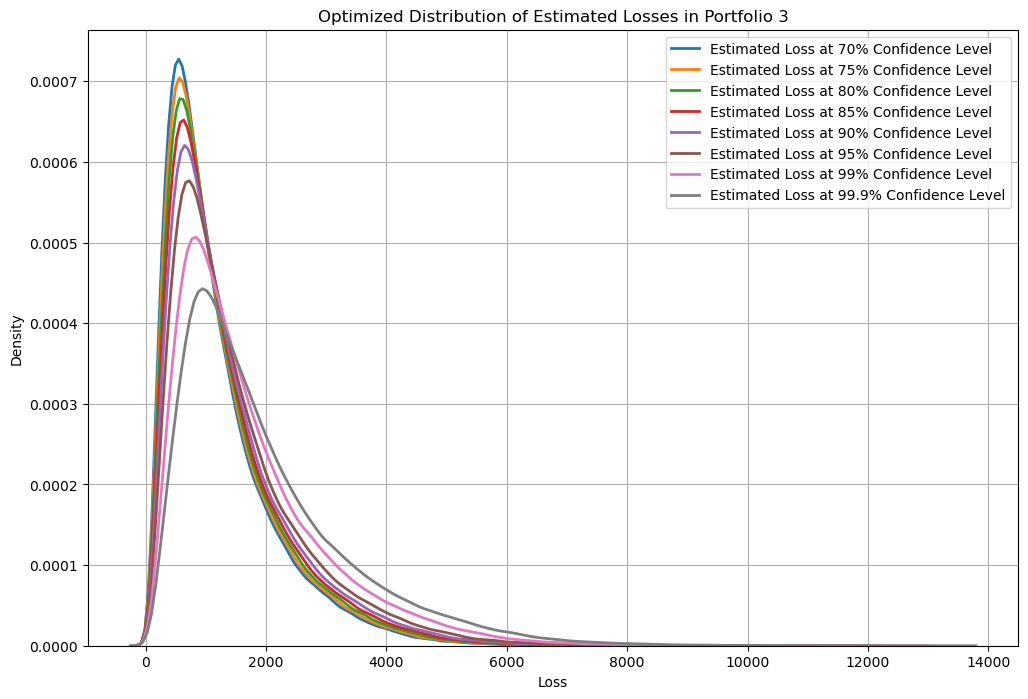

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure column names are stripped of any extra whitespace
df_12.columns = df_12.columns.str.strip()

# List of columns to plot
loss_columns = [
    'Estimated_Loss_700', 'Estimated_Loss_750', 'Estimated_Loss_800', 'Estimated_Loss_850',
    'Estimated_Loss_900', 'Estimated_Loss_950', 'Estimated_Loss_990', 'Estimated_Loss_999'
]

# Rename columns for clarity in the plot
column_names = {
    'Estimated_Loss_700': 'Estimated Loss at 70% Confidence Level',
    'Estimated_Loss_750': 'Estimated Loss at 75% Confidence Level',
    'Estimated_Loss_800': 'Estimated Loss at 80% Confidence Level',
    'Estimated_Loss_850': 'Estimated Loss at 85% Confidence Level',
    'Estimated_Loss_900': 'Estimated Loss at 90% Confidence Level',
    'Estimated_Loss_950': 'Estimated Loss at 95% Confidence Level',
    'Estimated_Loss_990': 'Estimated Loss at 99% Confidence Level',
    'Estimated_Loss_999': 'Estimated Loss at 99.9% Confidence Level'
}

# Plot the distributions
plt.figure(figsize=(12, 8))
for col in loss_columns:
    sns.kdeplot(df_12[col], label=column_names[col], linewidth=2)

plt.xlabel('Loss')
plt.ylabel('Density')
plt.title('Optimized Distribution of Estimated Losses in Portfolio 3')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Group the DataFrame by 'issue_year' and 'issue_month'
grouped = df_12.groupby(['issue_y', 'issue_m'])

# Initialize a dictionary to store results
results = {
    'loss': [],
    'Estimated_Loss_700': [],
    'Estimated_Loss_750': [], 
    'Estimated_Loss_800': [],
    'Estimated_Loss_850': [],
    'Estimated_Loss_900': [],
    'Estimated_Loss_950': [],
    'Estimated_Loss_990': [],
    'Estimated_Loss_999': []
}

# Calculate sums for each group
for name, group in grouped:
    for key in results.keys():
        results[key].append(group[key].sum())

# Convert to DataFrame for easier comparison
results_df = pd.DataFrame(results, index=grouped.size().index.rename(['Year', 'Month']))

# Frequency of actual loss sum exceeding estimated loss sums
frequencies = {}
for col in results_df.columns[1:]:  # Skip the first column which is 'loss'
    frequencies[col] = np.sum(results_df['loss'] > results_df[col])

frequencies

{'Estimated_Loss_700': 20,
 'Estimated_Loss_750': 17,
 'Estimated_Loss_800': 14,
 'Estimated_Loss_850': 14,
 'Estimated_Loss_900': 13,
 'Estimated_Loss_950': 11,
 'Estimated_Loss_990': 3,
 'Estimated_Loss_999': 0}

In [8]:
from scipy.stats import chi2
# Total number of trials (days)
n = 84
# Observed number of exceedances for each confidence level
exceedances = {'Estimated_Loss_700': 20,
 'Estimated_Loss_750': 17,
 'Estimated_Loss_800': 14,
 'Estimated_Loss_850': 14,
 'Estimated_Loss_900': 13,
 'Estimated_Loss_950': 11,
 'Estimated_Loss_990': 3,
 'Estimated_Loss_999': 0}

# Calculate Kupiec's test statistic and p-value for each confidence level
results = {}
for level, exceptions in exceedances.items():
    # Extract the numeric value from the level key
    confidence_percentage = int(level.split('_')[-1])
    # Calculate p from the confidence percentage
    p = (1000 - confidence_percentage) / 1000
    
    # Handle edge cases for log calculations
    p = max(p, 1e-10)  # prevent log(0)
    q = 1 - p
    q = max(q, 1e-10)  # prevent log(0)
    proportion = exceptions / n
    proportion = max(proportion, 1e-10)  # prevent log(0)
    one_minus_proportion = 1 - proportion
    one_minus_proportion = max(one_minus_proportion, 1e-10)  # prevent log(0)
    
    # Compute the components for the Kupiec test
    ln_part_model = (n - exceptions) * np.log(q) + exceptions * np.log(p)
    ln_part_actual = (n - exceptions) * np.log(one_minus_proportion) + exceptions * np.log(proportion)
    test_statistic = -2 * (ln_part_model - ln_part_actual)
    
    # Calculate the p-value
    p_value = chi2.sf(test_statistic, 1)  # survival function for chi-squared distribution

    # Store the results
    results[level] = {
        'Test Statistic': test_statistic,
        'p-value': p_value,
        'Model Accepted': p_value > 0.05
    }

results

{'Estimated_Loss_700': {'Test Statistic': 1.602408403716126,
  'p-value': 0.2055622385027977,
  'Model Accepted': True},
 'Estimated_Loss_750': {'Test Statistic': 1.0642484772390475,
  'p-value': 0.3022482020260313,
  'Model Accepted': True},
 'Estimated_Loss_800': {'Test Statistic': 0.6100756426049827,
  'p-value': 0.43475933078832085,
  'Model Accepted': True},
 'Estimated_Loss_850': {'Test Statistic': 0.17772661695398995,
  'p-value': 0.6733342733342692,
  'Model Accepted': True},
 'Estimated_Loss_900': {'Test Statistic': 2.440409269446562,
  'p-value': 0.11824537090150253,
  'Model Accepted': True},
 'Estimated_Loss_950': {'Test Statistic': 8.178483202322766,
  'p-value': 0.004239019098652098,
  'Model Accepted': False},
 'Estimated_Loss_990': {'Test Statistic': 3.374390107462837,
  'p-value': 0.06621708391498586,
  'Model Accepted': True},
 'Estimated_Loss_999': {'Test Statistic': 0.16808403924203238,
  'p-value': 0.6818202262657833,
  'Model Accepted': True}}